## UpLift моделирование

Данные в этом и последующих методах решения задачи uplift взяты с соревнования Retail Hero от X5 Retail http://retailhero.ai/#rec141268104

В соревновании предлагалось отранжировать клиентов X5 по убыванию эффективности коммуникации.

**Решение состоит из 5 этапов:**
- 1. Анализ и обработка признаков
- 2. Модель S-learner
- 3. Модель T-learner
- 4. Реализация подхода с трансформацией класса
- 5. Кратки анализ результатов по метрике uplift@30%

## 1. Анализ и обработка признаков

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# Установка необходимых пакетов
#!pip install catboost
#!pip install scikit-uplift
#!pip install causalml

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt

Загрузим данные

In [4]:
df_clietns = pd.read_csv('/gdrive/MyDrive/clients.csv', index_col='client_id')
df_train = pd.read_csv('/gdrive/MyDrive/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('/gdrive/MyDrive/uplift_test.csv', index_col='client_id')
df_clietns.head(3)

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F


Перейдем к более удобному представлению данных

In [5]:
df_features = df_clietns.copy()
# превратим время с момента регистрации в кол-во секунд начиная с 1970 г.
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date']) - pd.Timestamp('1970-01-01'))\
    // pd.Timedelta('1s')

# превратим время с момента первого действия в кол-во секунд начиная с 1970 г.
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# создадим производный признак, который определяет разницу между временем первого совершенного действия и момента регистрации
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']

# перейдем к более удобным признакам, удалив ненужные
df_features = df_features.drop(columns=['first_issue_date','first_redeem_date'], axis=1)

In [6]:
# возьмем индексы клиентов тренировочного и тестового наборов
indices_train = df_train.index
indices_test = df_test.index
# разобьем индексы тренировочного сета на учебный и валидный
indices_learn, indices_valid = train_test_split(df_train.index, test_size = 0.3, random_state = 42)

In [7]:
# новое представление
df_features.head(3)

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN


In [8]:
# индексы клиентов, флаг наличия воздействия, эффект оттока
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [9]:
# индексы клиентов теста
df_test.head(3)

""
client_id
000048b7a6
000073194a
00007c7133


In [10]:
# посмотрим на сколько наша задача неуравновешена
df_train.groupby('treatment_flg')['target'].describe()
# Практически идеальный баланс, 100000 на кого воздействовали и около 100000 на кого нет

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


Разделим на трейн, валид и тест в зависимости от наших индексов

In [11]:
# берем из нашего нового пространства признаков вектора, индексы которых мы разметили под обучение
X_train = df_features.loc[indices_learn, :]
# те же индексы берем из датафрейма с известными флагами воздействия и целевой переменной, тоесть берем целевую переменную
y_train = df_train.loc[indices_learn, 'target']
# из того же датасета берем признак воздействия, был или нет
treat_train = df_train.loc[indices_learn, 'treatment_flg']

Тоже самое проделаем для валидационных данных

In [12]:
X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

Построим трейны для полной модели, включающие все индексы тренировочного набора

In [13]:
X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

Строим X_test

In [14]:
X_test = df_features.loc[indices_test, :]

Разделим признаки:
- У нас один категорийный - gender

In [15]:
cat_features = ['gender']

Создадим словарь для результатов при uplift 30%

In [16]:
models_results = {'Модель' : [], 
                  'uplift@30%': []}

Функция для визуализации результатов

In [17]:
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Предсказания при наличии факта воздействия
        ctrl_preds (1d array-like): Предсказания при отсутствии факта воздействия
        log (bool): Логарифмическое скалирование (True or False)
        bins (integer): Кол-во бинов при отображении
    """

    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

## 2.Построим SoloModel

**Работа S-leaner очень проста для понимания:**
- 1. Берем заранее накопленных в бд клиентов, исход воздействия на которых известен
- 2. Строим две одинаковых, за исключением фактора воздействия(1/0), матрицы признаков для каждого клиента
- 3. Разницы между двуми условными вероятностями (P(Y = 1|W = 1) - P(Y = 1|W = 0)) и будет нашим uplift значением для каждого клиента

**Важно, что с точки зрения математики, смысла и решения наши модели идентичны**

In [18]:
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel # класс для построения uplift с одной моделью
from catboost import CatBoostClassifier # Как классификатор возьмем CatBoost

In [19]:
N =10000
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))

# X - описание векторов, У - отвечают за результат при факте воздействия, treat_train - само наличие воздействия
sm = sm.fit(X_train.iloc[:N,:], y_train.iloc[:N], treat_train.iloc[:N], estimator_fit_params={'cat_features': cat_features})

# Сделаем предикты для валидационного набора, которые впоследствии отсортируем от более желательных с точки зрения воздействия к менее желательным
uplift_sm = sm.predict(X_val)

# метрика для uplitf
# передаем валидационные y, предсказанный uplift для тех-же самых объектов, информацию о воздейтсвии на те-же объекты
# k - оценка в процентах, сколько брать по uplift(очень грубо можно интерпретировать как какое-то кол-во денег,которые мы готовы потратить на вмешательства)
sm_score = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.3)

# Добавим модель в наш словарь
models_results['Модель'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [20]:
models_results

{'uplift@30%': [0.07230889249446715], 'Модель': ['SoloModel']}

Мы получили uplift примерно в 7%

Можно сказать, что без воздействия на клиентов, то мы получили бы отток примерно на 7% от прогноза оттока

Отрисуем конретное решение, для этого необходимо получить условные вероятности для каждого объекта с взаимодействием и без него

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07cf373a10>,
      dtype=object)

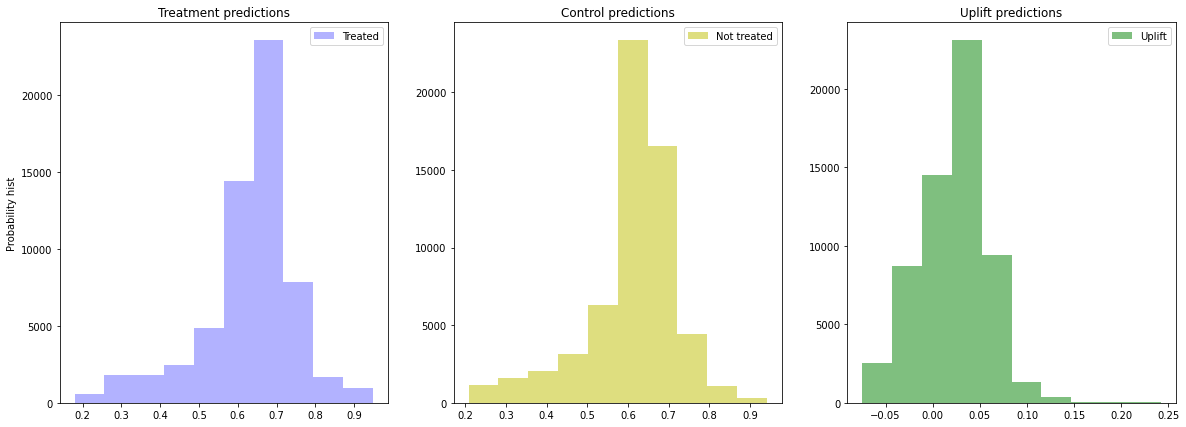

In [21]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отобразим распределения вероятностей и их разность (uplift)
plot_uplift_preds_(sm_trmnt_preds , sm_ctrl_preds, bins=10)

1. Первый график - это график с воздействием. Тут мы оцениваем вероятность того, что наш клиент совершит нужное действие при воздействии на него с помощью "звонка"
2. Второй график - это график без воздействия. Вероятность того, что клиент совершит необходимое дейтвие без "звонка"
3. Третий грфик - это их разница. Интрепретировать можно как стоит звонить/не стоит звонить. Но тут нужно понимать, что чем дальше в сторону +1, тем больше вероятность удачного взаимодействия. Клиенты левее нуля - это так называемые "спящие клиенты", которым звонить нельзя ни при каких условиях

### Что было сделано:
Мы построили одну общую модель(S-learner) на два варианта решения(с воздействием / без воздействия). При этом в трейне мы использовали клиентов, которые подвергались или не подвергались воздействию. При обучении SoloModel мы сначала обучили всю выборку на treatment = 1, затем на treatment=0, после чего нашли разницу вероятностей(3 график)

## 3.Построим TwoModels

**T-leaner - это две независимые модели, которые обучаются по отдельности**

Обучив модели по принципу:
- modelT = P(Y = 1|W = 1)
- modelC = P(Y = 1|W = 0)

Берем разницу prob положительных исходов моделей соответственно понятию положительного исхода для каждой модели, это и будет наш uplift

**Недостаток** заключается в том, что фактически мы построили разные модели. Поэтому желательно, чтобы модели были одного класса и совпадали по гиперпараметрам + необходимо проводить калибровку моделей.

In [22]:
from sklift.models import TwoModels

В модель передадим одинаковые модели с одинаковыми гиперпараметрами. Это не значит, что построенные модели будут полностью идентичны. На выходи мы получим два независимых, некалиброванных ответа от похожих задач.

In [23]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

In [24]:
# Тренируем, также передавая все три части данных(X, результат воздействия, наличие воздействия)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

Получим предикты и метрику

In [25]:
uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

# Добавляем результат модели в словарь для сравнения результатов
models_results['Модель'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

Также посмотрим на распредедение вероятностей в решении T-learner

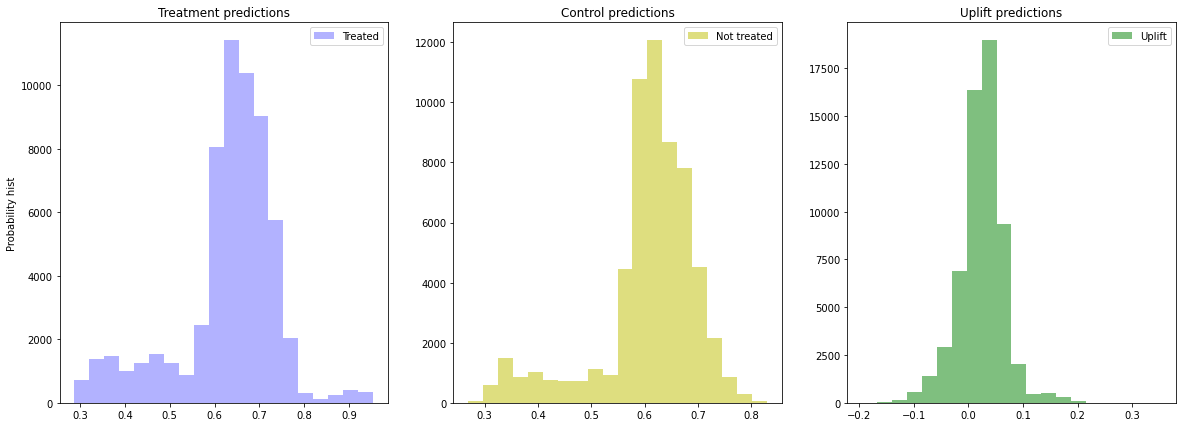

In [26]:
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_, bins=20);

Сравним два типа подхода к решению задачи uplift.

In [27]:
pd.DataFrame(data=models_results)

,Модель,uplift@30%
0,SoloModel,0.072309
1,TwoModels,0.060440


Мы можем наблюдать, что сольная модель справилась с задачей лучше двух независимых моделей. Но следует заметить, что T-learner не откалиброван и при должной калибровке возможно выдаст более лучшие результаты

## 4.Подход с использование трансформации класса

В данном подходе нам нужно найти тех клиентов, которые интересуют нас как цель:
- Клиенты, которых мы потеряем, если не "позвоним"
- Клиенты, которые независимо от факта воздействия останутся

В таком случае можно попробовать решить пробему, опираясь на трансформацию классов.
Мы построим агрегированный целевой признак, который будет объединять между собой ситуации воздействия и результата + отсутвие воздействия и отсутвие результата.

$$Z = Y*W +(1-Y)*(1-W)$$
Где:
- Z - новая целевая переменная клиента
- Y - целевая переменная клиента
- W - факт взаимодействия на клиента

Тогда на выходе интересующие нас объекты будут иметь Z = 1, а не интересующие Z = 0

**Не знаю, можно ли назвать это недостатком**,но в данном методе необходим баланс фактов воздействия. 

P.S. Конкретные данные не отбалансированы по treatment, результат может быть некорректным

In [28]:
from sklift.models import ClassTransformation

In [29]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


In [30]:
uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['Модель'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

## 5. Краткий анализ результатов с опором на ML-метрику

In [31]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending = False)

,Модель,uplift@30%
0,SoloModel,0.072309
2,ClassTransformation,0.065942
1,TwoModels,0.060440


Можем наблюдать, что трансформация класса дала прирост в 0.5% относительно T-learner

Однако балансировки взаимодействия и калибровки моделей S-learner показывает себя лучше всех, что не удивительно.

Также для каждой модели необходимо проводить тесты